In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
cars = pd.read_csv('all_car_adverts.csv')

In [3]:
cars.loc[~cars.year.str[0].isin(['1','2'])].reg.unique()
#The rows with missing years also have missing reg info. Just ditch these rows, there are too many to manually fill (~48k).

array([nan], dtype=object)

In [4]:
#Remove rows with missing years
carsclean = cars.loc[cars.year.str[0].isin(['1','2'])]

In [5]:
# Lets look at Fiestas.
fiestas = carsclean.loc[(cars.make=='Ford') & (cars.model=='Fiesta')]
fiestas = fiestas.reset_index()

In [6]:
# Check rows with missing engine volume
fiestas.loc[fiestas.engine_vol.isna(), ['car_sub_title','engine_vol']]

,car_sub_title,engine_vol
1760,1.0T EcoBoost Titanium Hatchback 5dr Petrol Ma...,NaN
2744,1.6T EcoBoost ST-2 Hatchback 3dr Petrol Manual...,NaN
2785,1.6T EcoBoost ST-2 With Nav & 330 BHP,NaN
2832,1.5T EcoBoost ST-2 Hatchback 3dr Petrol Manual...,NaN
3351,ST-3 Hatchback 3dr Petrol Manual Euro 6 (s/s) ...,NaN
3372,1.5T EcoBoost ST-3 Hatchback 3dr Petrol Manual...,NaN
3519,NaN,NaN
3595,1.0T EcoBoost ST-Line Hatchback 3dr Petrol Man...,NaN
3941,1.0T EcoBoost GPF ST-Line Hatchback 5dr Petrol...,NaN
4616,1.0T EcoBoost ST-Line Edition Hatchback 5dr Pe...,NaN


In [7]:
# Insert missing engine volume where possible based on car_sub_title
fiestas.loc[1760,'engine_vol'] = 1.0
fiestas.loc[2744,'engine_vol'] = 1.6
fiestas.loc[2785,'engine_vol'] = 1.6
fiestas.loc[2832,'engine_vol'] = 1.5
fiestas.loc[3372,'engine_vol'] = 1.5
fiestas.loc[3595,'engine_vol'] = 1.0
fiestas.loc[3941,'engine_vol'] = 1.0
fiestas.loc[4616,'engine_vol'] = 1.0
fiestas.loc[4767,'engine_vol'] = 1.0
fiestas.loc[6790,'engine_vol'] = 1.0
fiestas.loc[7866,'engine_vol'] = 1.1
fiestas.loc[9226,'engine_vol'] = 1.0
fiestas.loc[9290,'engine_vol'] = 1.0
fiestas.loc[10611,'engine_vol'] = 1.25
fiestas.loc[10691,'engine_vol'] = 1.6

In [8]:
# Remove remaining rows with missing engine volume and convert year to float
fiestas = fiestas.loc[~fiestas.engine_vol.isna()]
fiestas.year = fiestas.year.astype('float64')

In [9]:
# Create a base dataframe with just the features we want to use for modelling
fiestasbase = fiestas.loc[:,['year','miles', 'engine_vol','car_price']].copy()

In [10]:
# Check for missing values in the base dataframe
print(len(fiestasbase.loc[np.isnan(fiestasbase.year)]),
len(fiestasbase.loc[np.isnan(fiestasbase.miles)]),
len(fiestasbase.loc[np.isnan(fiestasbase.car_price)]))

0 98 0


In [11]:
# Remove rows with missing miles
fiestasbase = fiestasbase.drop(fiestasbase.loc[np.isnan(fiestasbase.miles)].index)

In [12]:
# Split into training and testing data
traindata = fiestasbase.sample(frac=0.8, random_state=42)
testdata = fiestasbase.drop(traindata.index)

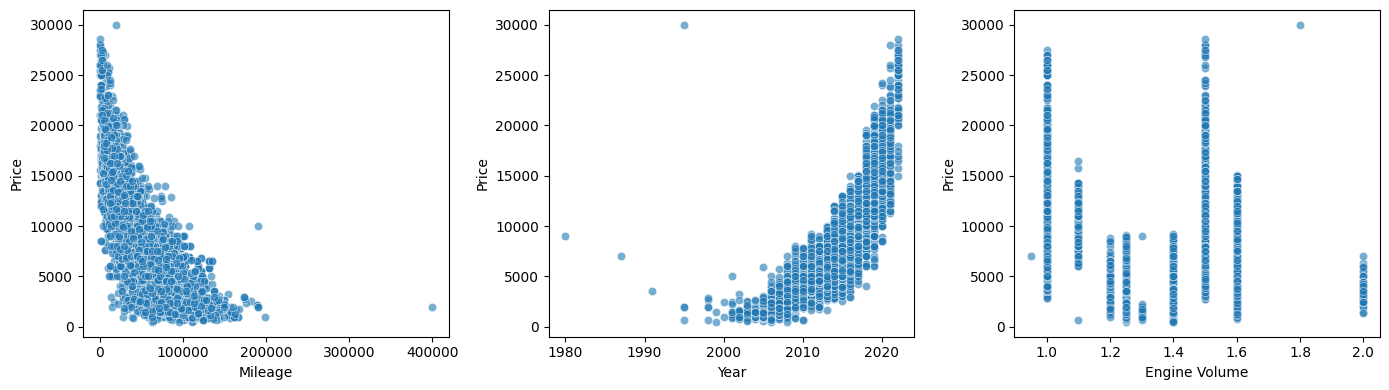

In [13]:
# Have a look at the relationships between the features and the price
plt.figure(figsize=(14,4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=traindata, x='miles', y='car_price', alpha=0.6)
plt.xlabel('Mileage')
plt.ylabel('Price')

plt.subplot(1, 3, 2)
sns.scatterplot(data=traindata, x='year', y='car_price', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Price')

plt.subplot(1, 3, 3)
sns.scatterplot(data=traindata, x='engine_vol', y='car_price', alpha=0.6)
plt.xlabel('Engine Volume')
plt.ylabel('Price')

plt.tight_layout()

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
# Split features and labels
trainfeats = traindata.copy()
testfeats = testdata.copy()

trainlabels = trainfeats.pop('car_price')
testlabels = testfeats.pop('car_price')

In [16]:
# Function for compiling and fitting a model, specifying learning rate and number of epochs
def compile_and_fit(model_name, learning_rate, epochs):
    model_name.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    history = model_name.fit(
        trainfeats,
        trainlabels,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2
    )
    return history

In [17]:
# Function for drawing plots to evaluate a model's performance
def evaluate(m):
    
    y_test = np.array(testlabels)
    y_pred = m.predict(testfeats).flatten()
    residuals = y_test - y_pred


    plt.figure(figsize=(18, 5))

    # --- Plot 0: Loss Curves ---
    plt.subplot(1, 4, 1)
    plt.plot(m_out[m.name].history['loss'], label='loss')
    plt.plot(m_out[m.name].history['val_loss'], label='val_loss')
    #plt.ylim([0,10000000])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Loss Curve')

    # --- Plot 1: Actual vs Predicted ---
    plt.subplot(1, 4, 2)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    min_val = min(np.min(y_test), np.min(y_pred))
    max_val = max(np.max(y_test), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5) # The zero error line
    plt.title('Actual vs. Predicted')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')

    # --- Plot 2: Residual vs Predicted ---
    plt.subplot(1, 4, 3)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--', lw=1.5) # The zero error line
    plt.title('Residuals vs. Predicted')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals (Actual - Predicted)')

    # --- Plot 3: Error Distribution ---
    plt.subplot(1, 4, 4)
    sns.histplot(residuals, kde=True, bins=45)
    plt.axvline(x=0, color='r', linestyle='--', lw=1.5) # The zero error line
    plt.title('Distribution of Residuals')
    plt.xlabel('Prediction Error')

    # Formatting
    plt.tight_layout()
    plt.suptitle(f'Model: {m.name}. MSE: {(1/len(y_test))*(sum(y_test - y_pred )**2):,.0f}', fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()

In [18]:
# Set up normalizer layer and adapt to training features
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(trainfeats))

In [19]:
# Set up some different models to compare performance
m_linear = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1, activation='relu'),
], name='Linear')

m_1hl = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1, activation='relu'),    
], name='1HiddenLayer')

m_3hl = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1, activation='relu'),    
], name='3HiddenLayers')

m_5hl = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1, activation='relu'),    
], name='5HiddenLayers')

models = [m_linear, m_1hl, m_3hl, m_5hl]

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


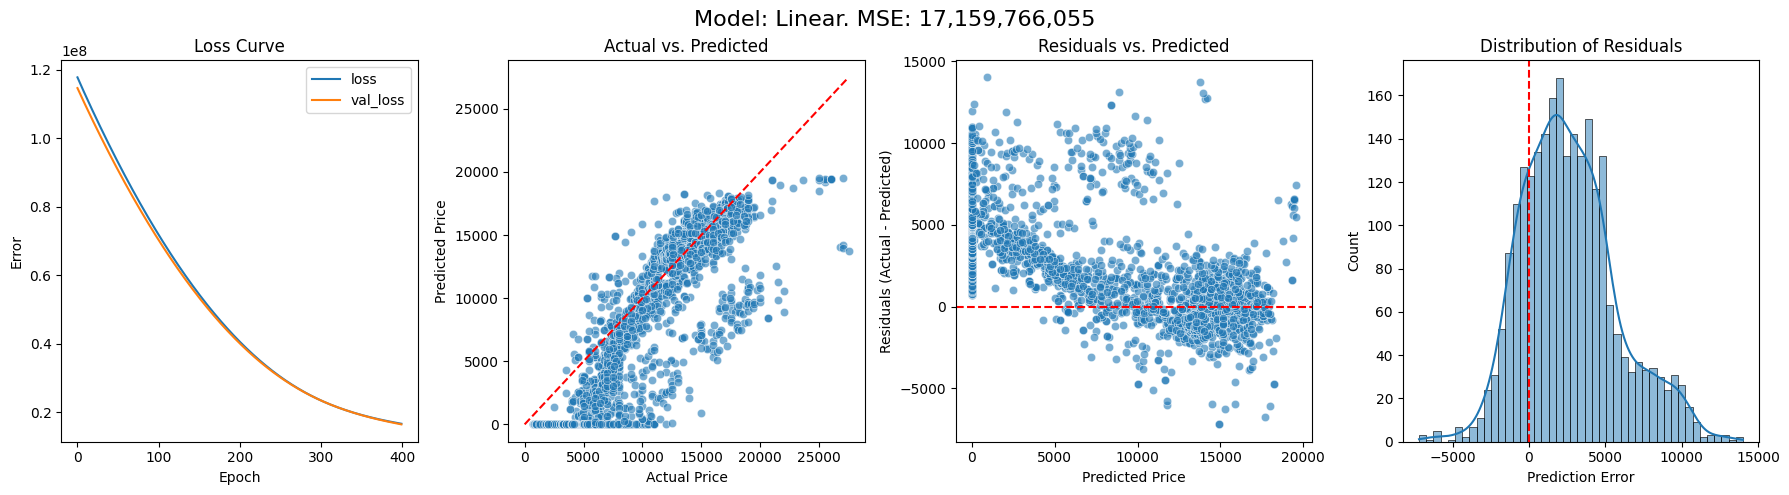

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


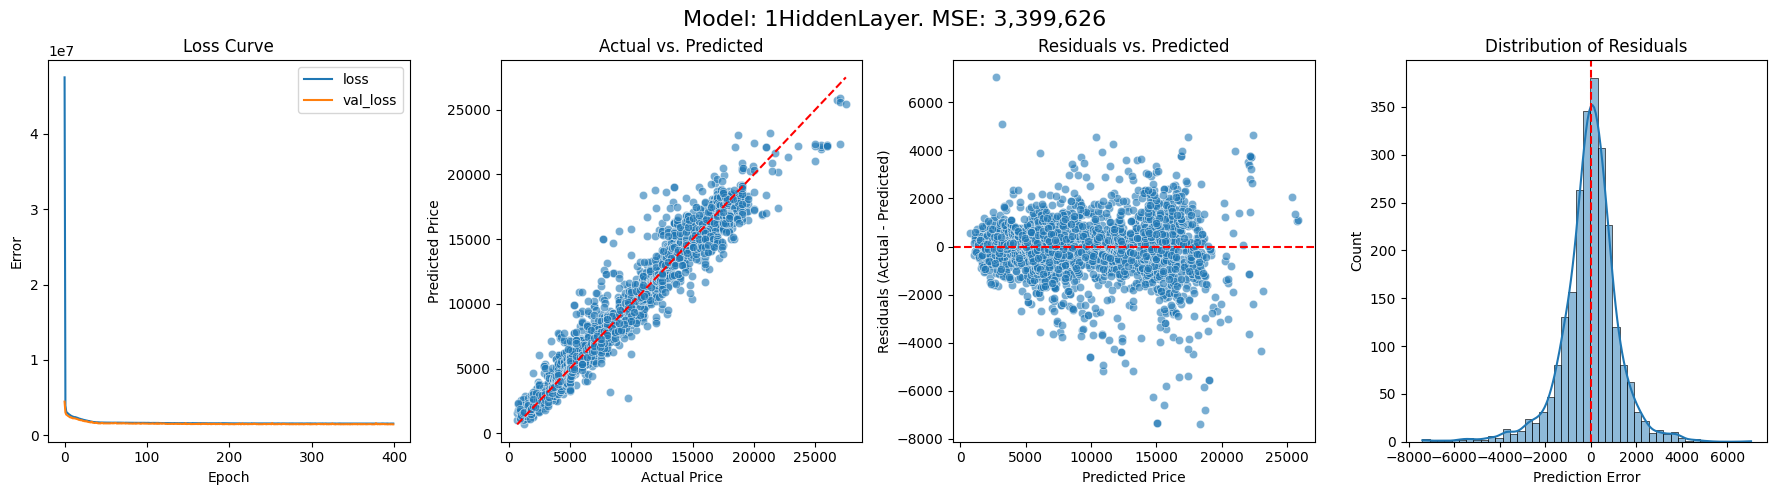

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


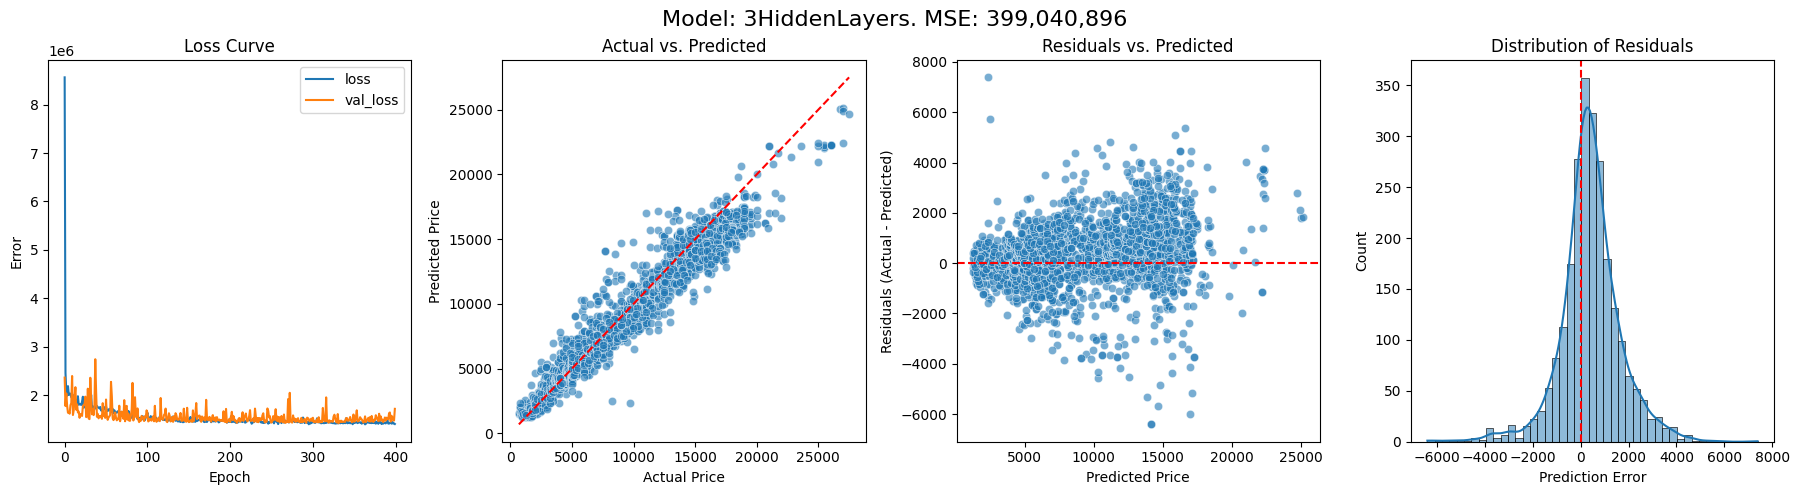

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


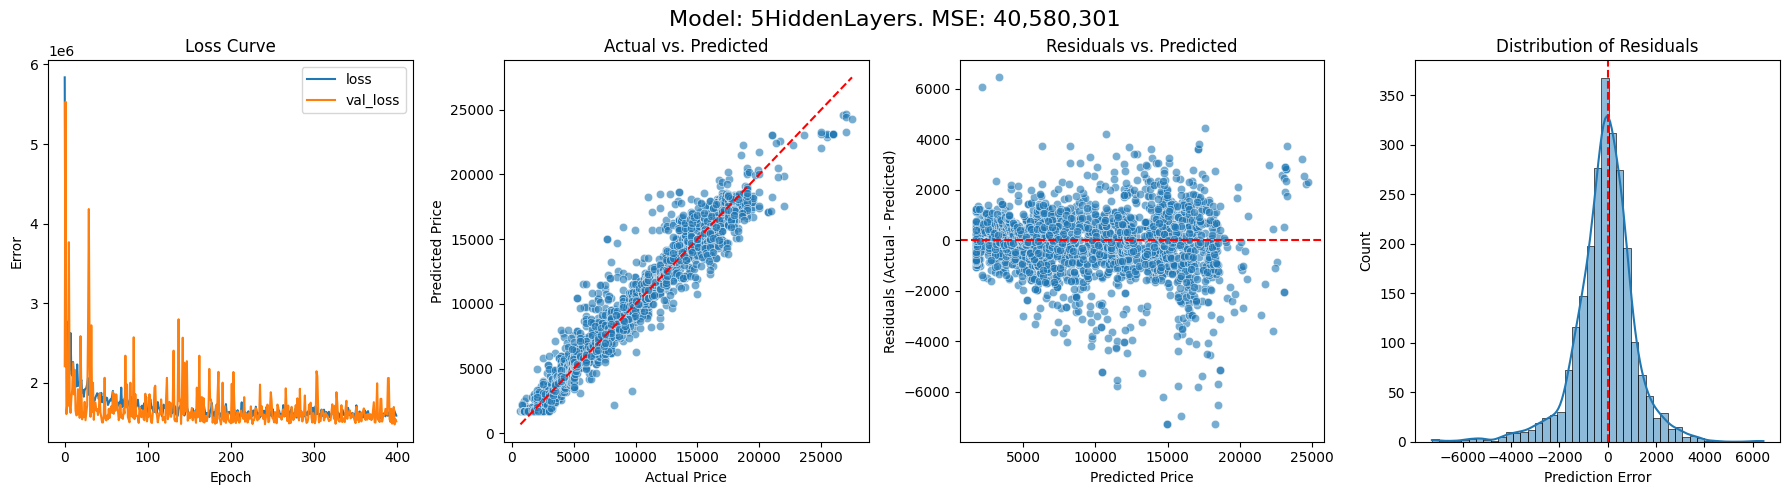

In [20]:
# Compile, fit and evaluate each model
m_out = {m.name :compile_and_fit(m, 0.05, 400) for m in models}
for m in models:
    evaluate(m)